In [1]:
import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pygeostat as gs

print("pygeostat version:", gs.__version__)

pygeostat version: 1.1.0


In [2]:
# import Outlier class from outlier.py
from outlier import Outlier

In [3]:
example = "ex2"
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "figures")
os.makedirs(IMAGES_PATH, exist_ok=True)


def savefig(fig_id, tight_layout=True, fig_extension="pdf", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Load Data

In [4]:
comps = gs.DataFile(
    data=pd.read_csv("./composites_tabular.csv"), x="x", y="y", z="z"
)
comps.data = comps.data.dropna()
comps["length"] = comps["to"] - comps["from"]
comps.head()

,dhid,from,to,x,y,z,xstart,ystart,zstart,xend,yend,zend,zone,var,length
0,237.0,124.30,124.61,545.951532,567.225800,252.589012,545.955410,567.142636,252.887624,545.947654,567.308966,252.290400,2.0,1.01346,0.31
1,237.0,124.61,125.00,545.942838,567.413588,251.914726,545.947646,567.308966,252.290400,545.938030,567.518212,251.539054,2.0,0.19110,0.39
2,237.0,125.00,126.00,545.925950,567.786468,250.575782,545.937920,567.518216,251.539056,545.913980,568.054720,249.612506,2.0,2.38056,1.00
3,237.0,126.00,126.79,545.904936,568.266624,248.851512,545.914028,568.054718,249.612506,545.895846,568.478528,248.090516,2.0,2.61030,0.79
4,237.0,126.79,127.10,545.892434,568.561676,247.791894,545.895914,568.478526,248.090514,545.888954,568.644824,247.493274,2.0,1.28142,0.31


In [5]:
comps.write_file("composites.dat")

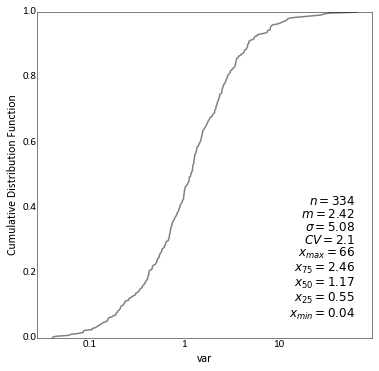

In [6]:
gs.histogram_plot(comps, "var", icdf=1, logx=True, figsize=(6, 6))

Saving figure outlier_ex2_drillplot


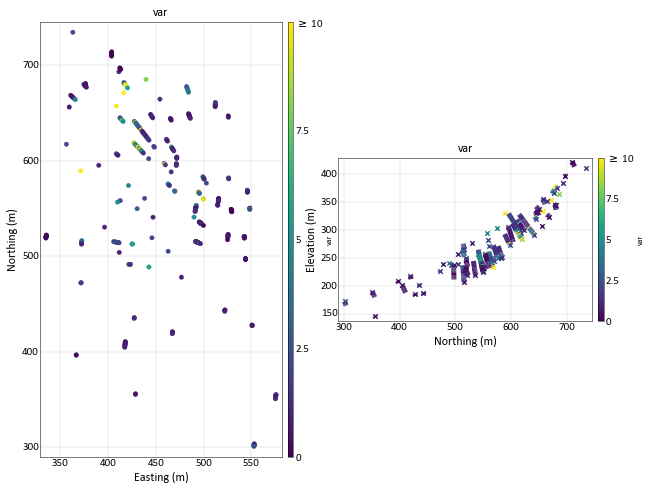

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(10, 8))
gs.location_plot(
    comps,
    var="var",
    orient="xy",
    vlim=(0, 10),
    ax=ax[0],
    cbar_label="var",
    grid=True,
)
gs.location_plot(
    comps,
    var="var",
    orient="yz",
    vlim=(0, 10),
    ax=ax[1],
    cbar_label="var",
    grid=True,
)
savefig(f"outlier_{example}_drillplot", tight_layout=False)

# Decluster

In [8]:
declus = gs.Program("declus", getpar=True)

D:\03 UofA\04 Research\02 PhD\Code\Outlier Class\tmpklvv__mc/declus.par has been copied to the clipboard


In [9]:
parstr = """                  Parameters for DECLUS
                  *********************

START OF PARAMETERS:
composites.dat         -file with data
4   5   6   14               -  columns for X, Y, Z, and variable
-998     1.0e21          -  trimming limits
declus.sum                  -file for summary output
declus.out                  -file for output with data & weights
1.0   1.0                   -Y and Z cell anisotropy (Ysize=size*Yanis)
0                           -0=look for minimum declustered mean (1=max)
25  50  750               -number of cell sizes, min size, max size
50                           -number of origin offsets
"""
declus.run(parstr=parstr, liveoutput=False)

Calling:  ['declus', 'temp']


In [10]:
sum_fl = gs.DataFile("declus.sum")

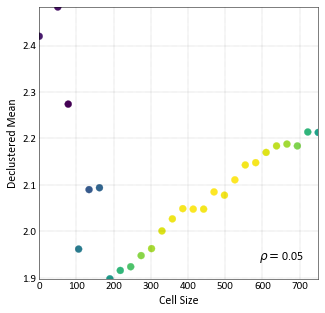

In [11]:
gs.scatter_plot(
    sum_fl["Cell Size"], sum_fl["Declustered Mean"], grid=True, figsize=(5, 5)
)

In [12]:
parstr = """                  Parameters for DECLUS
                  *********************

START OF PARAMETERS:
composites.dat         -file with data
4   5   6   14               -  columns for X, Y, Z, and variable
-998     1.0e21          -  trimming limits
declus.sum                  -file for summary output
declus.out                  -file for output with data & weights
1.0   1.0                   -Y and Z cell anisotropy (Ysize=size*Yanis)
0                           -0=look for minimum declustered mean (1=max)
1  100  100               -number of cell sizes, min size, max size
50                          -number of origin offsets
"""
declus.run(parstr=parstr, liveoutput=False)

Calling:  ['declus', 'temp']


In [13]:
comps = gs.DataFile("declus.out").data.rename(
    columns={"Declustering Weight": "wts"}
)
comps.describe()

,dhid,from,to,x,y,z,xstart,ystart,zstart,xend,yend,zend,zone,var,length,wts
count,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000
mean,612.155689,220.189281,221.044491,465.931944,560.803257,269.540216,464.287768,558.717903,268.491059,463.998470,559.310962,267.011722,1.637725,2.420418,0.855210,1.000000
std,277.961260,124.882069,124.883360,59.414183,87.886426,57.813891,60.748892,88.031886,57.874861,60.893100,88.206245,58.047968,0.481379,5.086477,0.259595,1.113898
min,237.000000,108.950000,109.900000,334.879446,301.007750,143.647812,321.506246,300.659746,144.589112,321.598926,301.355752,142.706512,1.000000,0.040800,0.070000,0.285377
25%,435.250000,127.000000,128.000000,418.833285,515.225449,227.897792,419.212957,514.273784,225.814400,418.453613,514.369449,224.007102,1.000000,0.547170,0.700000,0.396213
50%,450.500000,134.600000,135.070000,468.552627,559.939611,254.431013,464.967074,559.799224,252.877002,464.563351,560.080000,250.999115,2.000000,1.172360,1.000000,0.599519
75%,962.000000,370.500000,371.177500,514.901891,628.169596,312.347148,514.865932,627.550310,312.985239,514.937850,628.788882,311.709055,2.000000,2.457105,1.000000,1.242244
max,1043.000000,436.000000,437.000000,575.901802,734.682221,423.027428,575.867252,724.748282,423.926306,575.936352,725.119900,422.128552,2.000000,66.004680,1.930000,10.332108


# Despike

In [14]:
despike = gs.Program("despike_2000", getpar=True)

D:\03 UofA\04 Research\02 PhD\Code\Outlier Class\tmpe7urbal8/despike_2000.par has been copied to the clipboard


In [15]:
parstr = """                  Parameters for Despike_2000
                  ***************************

START OF PARAMETERS:
declus.out                   -file with data
4 5 6  14  0                -columns for X, Y, Z, Var, and rock type
0  0  0                      -number valid RTs and their integer codes
-998   1.0e21             -trimming limits
10                           -number of NN for local average
0.5                          -Weight W1 for random component (between [0-1])
69069                        -Random Seed
despike.out                  -file for output
"""
despike.run(parstr, liveoutput=False)

Calling:  ['despike_2000', 'temp']


In [16]:
comps = gs.DataFile("despike.out").data.rename(
    columns={"Declustering Weight": "wts"}
)
comps.head()

,dhid,from,to,x,y,z,xstart,ystart,zstart,xend,yend,zend,zone,var,length,wts,DS-var
0,237.0,124.30,124.61,545.951532,567.225800,252.589012,545.955410,567.142636,252.887624,545.947654,567.308966,252.290400,2.0,1.01346,0.31,1.019202,1.01346
1,237.0,124.61,125.00,545.942838,567.413588,251.914726,545.947646,567.308966,252.290400,545.938030,567.518212,251.539054,2.0,0.19110,0.39,1.019202,0.19110
2,237.0,125.00,126.00,545.925950,567.786468,250.575782,545.937920,567.518216,251.539056,545.913980,568.054720,249.612506,2.0,2.38056,1.00,0.885602,2.38056
3,237.0,126.00,126.79,545.904936,568.266624,248.851512,545.914028,568.054718,249.612506,545.895846,568.478528,248.090516,2.0,2.61030,0.79,0.791848,2.61030
4,237.0,126.79,127.10,545.892434,568.561676,247.791894,545.895914,568.478526,248.090514,545.888954,568.644824,247.493274,2.0,1.28142,0.31,0.791848,1.28142


# Initilaize Outlier Class

In [17]:
var = "DS-var"
length = "length"
wts = "wts"
outlier = Outlier(data=comps, x="x", y="y", z="z", wts=wts, length=length)

# Probability Plots

- Cummulative probability plots with the option to set a threshold and flag samples
- Option to display Tukey's Fences

Saving figure outlier_ex2_cpp


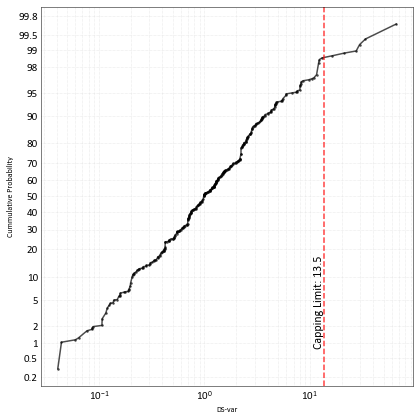

In [28]:
fig, ax = outlier.probplot(
    var, wts=wts, thresh=13.5, tukeys_fences=False, logx=True, figsize=(6, 6),
)
savefig(f"outlier_{example}_cpp")

Saving figure outlier_ex2_cpp_tukey


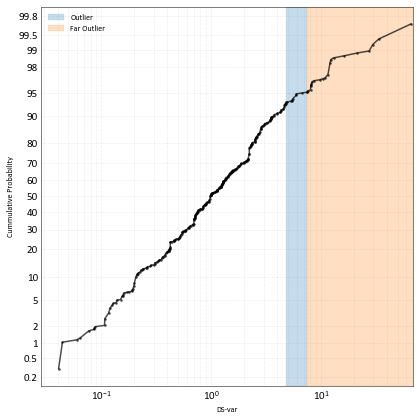

In [19]:
# with Tukey's Fences
fig, ax = outlier.probplot(
    var, wts=wts, thresh=None, tukeys_fences=True, logx=True, figsize=(6, 6),
)
savefig(f"outlier_{example}_cpp_tukey")

# Decile Analysis

- Decile analysis after Parrish (1997): "Geologist's Gordian Knot - To Cut Or Not To Cut"
- General recommendations are to check if:
    - The upper decile contains more than 40% of the total metal
    - The upper decile contains more than 2x the total metal of the previous decile
    - The upper percentile contains more than 10% of the total metal
- All decile and percentile statistics are weighted by assay length
- The lower threshold can be used to remove samples, for example samples at detection limit

In [20]:
decile = outlier.parrish_table(var, length)
display(decile)

The upper decile contains more than 40% of the total metal: capping is recommended

The upper decile contains more than 2x the total metal of the previous decile: capping is recommended

The upper percentile contains more than 10% of the total metal (weighted by count): capping is recommended



,count,mean,std,min,25%,50%,75%,max,Metal,% Total
Decile,,,,,,,,,,
0,34,0.14,0.05,0.04,0.11,0.15,0.19,0.23,4.5,0.7
1,34,0.34,0.06,0.23,0.29,0.35,0.40,0.43,10.0,1.5
2,34,0.56,0.07,0.43,0.51,0.55,0.62,0.68,15.9,2.4
3,34,0.78,0.07,0.70,0.72,0.76,0.84,0.90,23.3,3.5
4,34,1.06,0.08,0.92,0.99,1.02,1.12,1.19,27.0,4.0
5,34,1.32,0.09,1.21,1.26,1.29,1.37,1.51,41.4,6.2
6,34,1.82,0.23,1.51,1.59,1.77,2.02,2.17,51.0,7.6
7,34,2.57,0.23,2.22,2.36,2.53,2.75,3.05,78.3,11.6
8,34,4.02,0.61,3.06,3.48,3.87,4.62,5.30,116.0,17.3


- export table to csv

In [21]:
decile.data.to_csv(f"./parrish_decile_{example}.csv")

- export table to latex

In [22]:
formats = ["{:,.0f}", *("{:.2f} " * 7).split(" ")[:-1], "{:,.1f}", "{:.1f}"]
format_dict = {
    col: fmt.format for (col, fmt) in zip(decile.data.columns, formats)
}
decile.data.to_latex(
    f"./parrish_decile_{example}.tex",
    formatters=format_dict,
    label=f"tab:parrish_{example}",
    caption="Parrish decile analysis for a synthetic log-normal-like distribution.",
)

- calculating the decile table automatically sets the ```parrish_thresh``` attribute on the class

In [23]:
outlier.parrish_thresh

34.0

- an arbitrary threshold can be set and called at any time

In [24]:
outlier.set_threshold(13.5)
outlier.thresh

14.0

# Outlier Section Plots

- Simple inlier/outlier section plots based on a threshold

Saving figure outlier_ex2_xy


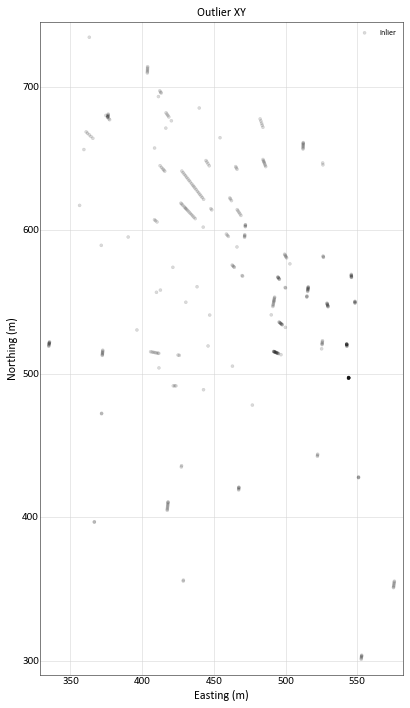

In [25]:
fig, ax = outlier.sectionplot(
    var,
    x="x",
    y="y",
    thresh=outlier.parrish_thresh,
    orient="xy",
    figsize=(6, 10),
    title="Outlier XY",
    pt_kws={"alpha": 0.15, "s": 10, "c": "k", "label": "Inlier"},
    out_kws={"alpha": 0.75, "s": 20, "ec": "k", "c": "r", "label": "Outlier"},
)
ax.legend()
savefig(f"outlier_{example}_xy")

Saving figure outlier_ex2_yz


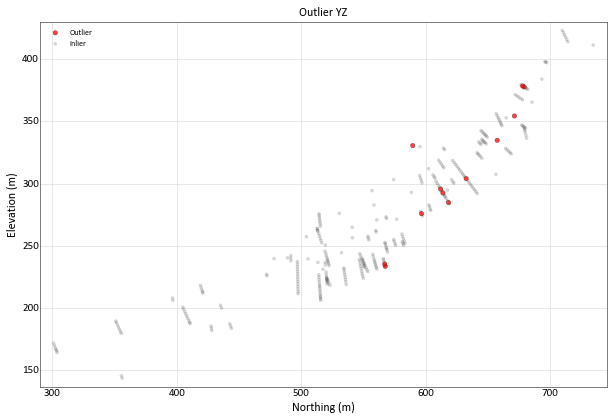

In [34]:
fig, ax = outlier.sectionplot(
    var,
    x="x",
    y="y",
    z="z",
    thresh=10, #outlier.parrish_thresh,
    orient="yz",
    figsize=(10, 6),
    title="Outlier YZ",
)
savefig(f"outlier_{example}_yz")

# Cutting Curves

- Cutting curves after Roscoe (1996): "Cutting curves for grade estimation and grade control in gold mines."

Saving figure outlier_ex2_cutting_curve


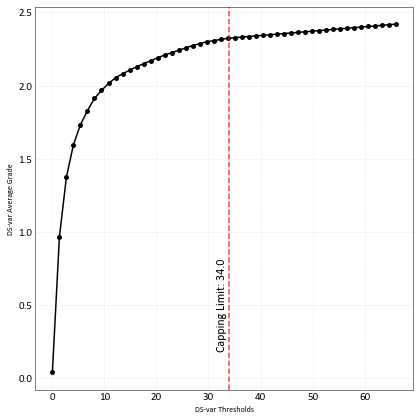

In [27]:
fig, ax = outlier.cutting_curve(
    var,
    num_thresh=50,
    plot_thresh=outlier.parrish_thresh,
    logx=False,
    figsize=(6, 6),
    marker=".",
    ms=10,
    c="k",
)
savefig(f"outlier_{example}_cutting_curve")

# Cumulative Coefficient of Variation
- Cumulative Coefficient of Variation after Parker (1991): "Statistical Treatment of Outlier Data in Epithermal Gold Deposit Reserve Estimation"
- The cumulative CV can be plotted and used to identify quantiles where there is a sudden acceleration in cumulative CV; this is where the influence of the outliers in the upper tail becomes strong.

In [28]:
ccv = outlier.cumcv(var, length)
ccv

,DS-var,length,grade_x_length,cum_mean,cum_std,cum_cv,cum_metal
0,66.00468,1.00,66.004680,2.420417,5.086477,2.101488,9.824098
1,33.66006,1.00,33.660060,2.229473,3.706214,1.662372,14.834042
2,29.63730,0.34,10.076682,2.134803,3.283899,1.538268,16.333850
3,27.47136,0.43,11.812685,2.051714,2.918504,1.422471,18.092043
4,21.23310,0.74,15.712494,1.974685,2.563903,1.298386,20.430682
...,...,...,...,...,...,...,...
329,0.07728,0.75,0.057960,0.057306,0.014972,0.261265,99.971534
330,0.06420,1.00,0.064200,0.052312,0.011517,0.220165,99.981090
331,0.06000,0.70,0.042000,0.048350,0.010236,0.211698,99.987341
332,0.04425,1.00,0.044250,0.042525,0.002440,0.057367,99.993927


Saving figure outlier_ex2_cumcv


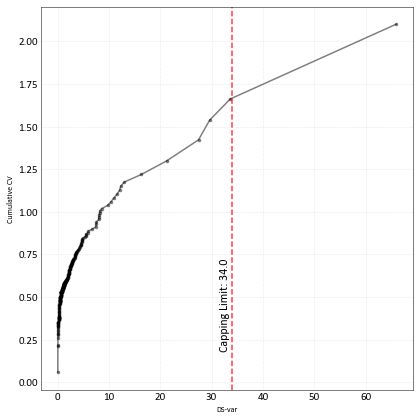

In [29]:
fig, ax = outlier.cumcv_plot(
    var,
    length,
    plot_thresh=outlier.parrish_thresh,
    figsize=(6, 6),
    marker=".",
    alpha=0.5,
    c="k",
)
savefig(f"outlier_{example}_cumcv")

# Mean Uncertainty

- Nowak et al. (2013): "SUGGESTIONS FOR GOOD GRADE CAPPING PRACTICES FROM HISTORICAL LITERATURE"
- Assess mean uncertainty using the spatial bootstrap
- A percentile of the data (```perc_to_cap```) can be omitted from the bootstrapping (potential capping candidates) to observe how removing data influences the expected mean versus the uncapped true mean
- The point of this exercise is an assessment of what could be an optimistic average grade in a domain if the highest ```perc_to_cap```% of the values are not used.
- If the uncapped average grade is much greater than the expected average grade after removing samples, capping may be warranted
- The variogram model for bootstrapping should be of the normal scores

In [30]:
vargstr = """2    0.1                         -nst, nugget effect
    1    0.4  45.0   0.0   0.0        -it,cc,ang1,ang2,ang3
    50.0  30.0  5.0        -a_hmax, a_hmiqiytn, a_vert
    1    0.5  45.0   0.0   0.0        -it,cc,ang1,ang2,ang3
    100.0  100.0  25.0        -a_hmax, a_hmin, a_vert"""

Saving figure outlier_ex2_mean_uncert


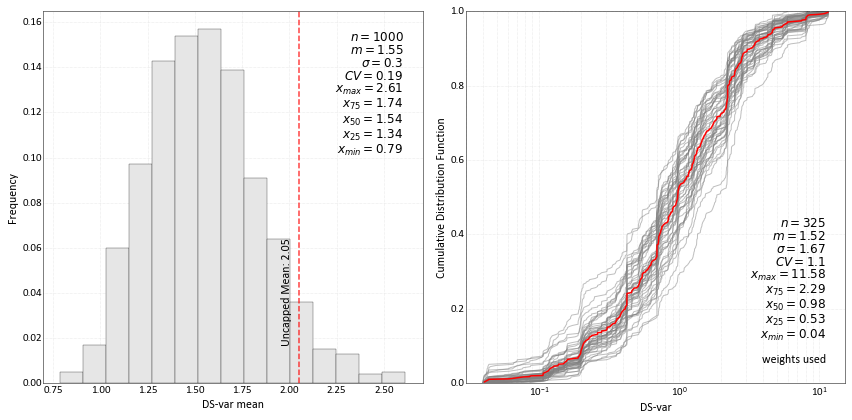

In [31]:
fig, ax = outlier.mean_uncertainty(
    var,
    wts=wts,
    vargstr=vargstr,
    perc_to_cap=2,
    seed=1658,
    nreals=1000,
    reals_to_plot=50,
    logx=True,
    figsize=(12, 6),
)
savefig(f"outlier_{example}_mean_uncert")

# Metal at Risk

- Metal at risk described by Parker (2006): "Technical Report of the Rock Creek Property, Nome, Alaska, USA" (pg. 17-18)
- Resample the assay distribution considering the number of assays (```nsamples```) available in a given production volume
    - typically ```nsamples``` is equal to tonnes per annual production volume / number of tonnes per assay in the domain
    - metal at risk accounts for the data density - as ```nsamples``` increases, metal at risk decreases
- Risk adjusted metal is the total metal below ```thresh``` plus P20 of the boostrapped metal above ```thresh```
- Metal at risk is the difference between the total expected metal and metal at risk 

In [32]:
risk = outlier.metal_at_risk(
    var,
    wts=wts,
    nsamples=50,
    thresh=13,
    seed=987654,
    nreals=1000,
)

In [33]:
risk

{'Number of Samples': 50,
 'HG Threshold': 13,
 'Expected HG Samples': 1,
 'Metal at Risk %': 45.48}

In [34]:
pd.DataFrame.from_dict(risk, orient="index").T.to_latex(
    f"./metal_at_risk_{example}.tex",
    label=f"tab:MAR_{example}",
    caption="Metal at risk for a synthetic log-normal-like distribution.",
    index=False,
)

# Metal Removed by Capping

Saving figure outlier_ex2_metal_removed


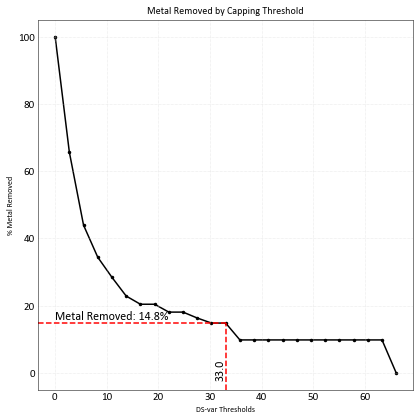

In [35]:
fig, ax = outlier.metal_removed(
    var,
    length,
    num_thresh=25,
    z=33.0,
    marker=".",
    c="k",
    line_kws={"colors": "r", "linestyles": "--"},
    title="Metal Removed by Capping Threshold",
    figsize=(6, 6),
)
savefig(f"outlier_{example}_metal_removed")